## AE-MSP plotting
* losses vs epoch
* evaluate orthogonality of projection matrix
* true vs predicted labels

In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from behavenet import get_user_dir, make_dir_if_not_exists

save_outputs = False  # true to save figures/movies to user's figure directory
format = 'png'  # figure format ('png' | 'jpeg' | 'pdf'); movies saved as mp4

### loss vs epoch

In [2]:
from behavenet.plotting import load_metrics_csv_as_df
# set model info
dataset = 'dipoppa'
hparams = {
    'data_dir': get_user_dir('data'),
    'save_dir': get_user_dir('save'),
    'experiment_name': 'latent_search',
    'model_class': 'cond-ae-msp',
    'model_type': 'conv',
    'n_ae_latents': 6,
}
if dataset == 'ibl':
    lab = 'ibl'
    expt = 'ephys'
    n_labels = 8
if dataset == 'dipoppa':
    lab = 'dipoppa'
    expt = 'MSP_pupil'
    n_labels = 3
else:
    raise Exception
hparams['n_ae_latents'] += n_labels
metrics_list = ['loss', 'loss_mse', 'loss_mse', 'r2']
metrics_df = load_metrics_csv_as_df(hparams, lab, expt, metrics_list, version='best')

NameError: name 'val_r2' is not defined

<Figure size 1152x864 with 0 Axes>

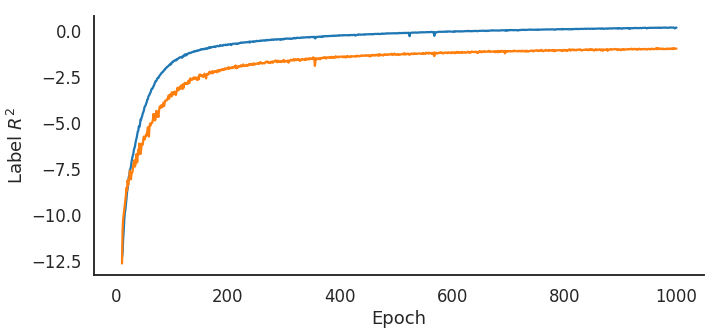

In [3]:
# plot data
sns.set_style('white')
sns.set_context('talk')

ys = ['r2']
fig = plt.figure(figsize=(16,12)) #plt.subplots(2, 2, figsize=(22,16))

for y in ys:
    
    data_queried = metrics_df[(metrics_df.epoch > 10) & ~pd.isna(metrics_df.loss)]
    g = sns.relplot(x='epoch', y=y, hue='dtype', kind='line', aspect=2, data=data_queried)
    g._legend.remove()

    plt.xlabel('Epoch')
    if y == 'loss':
        ax.set_ylabel('Total loss')
        ax.set_yscale('log')
    elif y == 'loss_mse':
        ax.set_ylabel('MSE per pixel')
        ax.set_yscale('log')
    elif y == 'loss_msp':
        ax.set_ylabel('MSE per label')
        ax.set_yscale('log')
    elif y == 'r2':
        plt.ylabel('Label $R^2$')

    if save_outputs:
        save_file = os.path.join(get_user_dir('fig'), 'ae', 'loss_vs_epoch')
        make_dir_if_not_exists(save_file)
        plt.savefig(save_file + '.' + format, dpi=300, format=format)

plt.scatter(1001, val_r2, marker='^', color='red', alpha=0.7, label='Val After Training')
plt.scatter(1001, test_r2, marker='v', color='purple', alpha=0.7, label='Test After Training')
plt.legend()
plt.show()

### true vs predicted labels

In [8]:
# from behavenet.data.utils import get_data_generator_inputs
# from behavenet.data.data_generator import ConcatSessionsGenerator
from behavenet.fitting.utils import get_best_model_and_data, get_lab_example
from behavenet.models import AEMSP

# movie info
save_outputs = False
dataset = 'dipoppa'
n_latents = 6 # n_labels will be added to this

# set model info
version = 'best' # 'best'  # test-tube version; 'best' finds the version with the lowest mse
sess_idx = 0  # when using a multisession, this determines which session is used
hparams = {
    'data_dir': get_user_dir('data'),
    'save_dir': get_user_dir('save'),
    'experiment_name': 'latent_search',
    'model_class': 'cond-ae-msp',
    'model_type': 'conv'}


lab = 'dipoppa'
expt = 'MSP_pupil'
trials = list(range(10))
n_labels = 3

# programmatically fill out other hparams options
hparams['n_ae_latents'] = n_latents + n_labels
get_lab_example(hparams, lab, expt)   

model, data_generator = get_best_model_and_data(
    hparams, AEMSP, load_data=True, version=0, data_kwargs=None)
n_labels = model.n_labels
print(data_generator)
print('\nmsp_weight: %1.2e' % model.hparams['msp_weight'])

Loading model defined in /home/samsung_2tb_ssd/yoni/results/dipoppa/MSP_pupil/SB028/6/cond-ae-msp/conv/09_latents/latent_search/version_0/meta_tags.pkl
Generator contains 1 SingleSessionDatasetBatchedLoad objects:
dipoppa_MSP_pupil_SB028_6
    signals: ['images', 'labels']
    transforms: OrderedDict([('images', None), ('labels', None)])
    paths: OrderedDict([('images', '/home/samsung_2tb_ssd/yoni/data/dipoppa/MSP_pupil/SB028/6/data.hdf5'), ('labels', '/home/samsung_2tb_ssd/yoni/data/dipoppa/MSP_pupil/SB028/6/data.hdf5')])


msp_weight: 1.00e+00


In [9]:
from behavenet.fitting.utils import create_tt_experiment, build_data_generator
from behavenet.fitting.utils import get_session_dir, get_expt_dir
from behavenet.data.utils import get_data_generator_inputs
from behavenet.data.data_generator import ConcatSessionsGenerator

hparams['session_dir'], sess_ids = get_session_dir(hparams)
hparams['expt_dir'] = get_expt_dir(hparams)
hparams, signals, transforms, paths = get_data_generator_inputs(hparams, sess_ids)

data_generator = ConcatSessionsGenerator(
    hparams['data_dir'], sess_ids, 
    signals_list=signals, transforms_list=transforms, paths_list=paths,
    device='cpu', as_numpy=False, batch_load=True, rng_seed=0)
trial = data_generator.datasets[sess_idx].batch_idxs['test'][2]  # trial to use in movie


In [ ]:
from behavenet.plotting.ae_utils import plot_neural_reconstruction_traces

all_labels = []
all_labels_pred = []
trials = data_generator.datasets[sess_idx].batch_idxs['test']

num_trials = 0
for trial in trials:
    print('Trial #{}'.format(trial))
    batch = data_generator.datasets[sess_idx][trial]
    labels_og = batch['labels'].detach().cpu().numpy()
    if labels_og.shape[0] != 150:
        continue 
        
    _, _, labels_pred = model(batch['images'])
    all_labels.append(labels_og)
    all_labels_pred.append(labels_pred.detach().numpy())
    num_trials += labels_og.shape[0]
    
labels_og = np.array(all_labels)
labels_pred = np.array(all_labels_pred)

Trial #63
Trial #33
Trial #203
Trial #173
Trial #123
Trial #233
Trial #183
Trial #133
Trial #243
Trial #153
Trial #23
Trial #113
Trial #143
Trial #93
Trial #73
Trial #193
Trial #53
Trial #103
Trial #83


In [ ]:
labels_og[0].shape, labels_pred[0][2].shape

In [ ]:
labels_og = np.zeros((num_trials, 3), float)
labels_pred = np.zeros((num_trials, 3), float)
for i in range(len(all_labels)):
    og_shape = all_labels[i].shape[0]
    pred_shape = all_labels_pred[i].shape[0]
    
    labels_og[i*og_shape:(i+1)*og_shape, :] = all_labels[i]
    labels_pred[i*pred_shape:(i+1)*pred_shape, :] = all_labels_pred[i]

In [ ]:
from sklearn.metrics import r2_score

plt.style.use('fivethirtyeight')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,10))
ax1.plot(labels_og[:, 0], label='Original Area')
ax1.plot(labels_pred[:, 0], label='Reconstructed')
r2 = r2_score(labels_og[:, 0], labels_pred[:, 0], multioutput='variance_weighted')
ax1.text(
            1.1, -1.3, '$R^2$=%1.3f' % r2, horizontalalignment='left', verticalalignment='bottom',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor=[1, 1, 1]))
ax1.set_title('Pupil Area Reconstruction')
ax1.set_xlabel('Frames (30 FPS)')

ax1.legend()

ax2.scatter(labels_og[:, 1], labels_og[:, 2], label='Original COM', alpha=0.4)
ax2.scatter(labels_pred[:, 1], labels_pred[:, 2], label='Reconstructed', alpha=0.9)
r2 = r2_score(labels_pred[:, 1:3], labels_og[:, 1:3], multioutput='variance_weighted')
ax2.text(
            0.05, 0.06, '$R^2$=%1.3f' % r2, horizontalalignment='left', verticalalignment='bottom',
            transform=plt.gca().transAxes,
            bbox=dict(facecolor='white', alpha=0.7, edgecolor=[1, 1, 1]))
ax2.set_title('Pupil Center of Mass Reconstruction')
ax2.legend()
labels_pred = labels_pred[:, :3]
plt.suptitle('Validation Data Labeled Latent Reconstruction')
print(labels_pred.shape)

In [19]:
val_r2 = r2_score(labels_og, labels_pred)

In [ ]:
plot_neural_reconstruction_traces(labels_og[:, :1], labels_pred[:, :1], scale=0.4)

In [ ]:
plt = plot_neural_reconstruction_traces(labels_og[:, 0:1], labels_pred[:, 0:1], scale=10)

### evaluate orthogonality of projection matrix

In [ ]:
U = model.U.weight.data.cpu().detach().numpy()

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
overlap = np.matmul(U, U.T)
m = np.max(np.abs(overlap))
plt.imshow(overlap, cmap='RdBu', vmin=-m, vmax=m)
plt.colorbar()
plt.show()

### plot all trials

In [ ]:
n_labels

In [ ]:
def plot_traces(
    traces, n_labels, save_file=None, xtick_locs=None, frame_rate=None, format='png', 
    scale=0.5):
    
    import matplotlib.pyplot as plt
    import matplotlib.lines as mlines
    import seaborn as sns

    sns.set_style('white')
    sns.set_context('poster')

    means = np.mean(traces, axis=0)
    std = np.std(traces, axis=0) / scale  # scale for better visualization

    traces_sc = (traces - means) / std

    fig = plt.figure(figsize=(12, 8))
    # plot label-related traces
    plt.plot(traces_sc[:, :n_labels] + np.arange(n_labels), linewidth=3)
    plt.plot(
        traces_sc[:, n_labels:] + n_labels + np.arange(traces.shape[1]-n_labels), 
        color=[0.2, 0.2, 0.2], linewidth=3)

    # add legend
    # original latents - gray
    orig_line = mlines.Line2D([], [], color=[0.2, 0.2, 0.2], linewidth=3)
    # predicted latents - cycle through some colors
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    dls = []
    for c in range(5):
        dls.append(mlines.Line2D(
            [], [], linewidth=3, linestyle='--', dashes=(0, 3 * c, 20, 1), 
            color='%s' % colors[c]))
    plt.legend(
        [orig_line, tuple(dls)], ['Unconstrained', 'Label-predicting'],
        loc='lower right', frameon=True, framealpha=0.7, edgecolor=[1, 1, 1])

    if xtick_locs is not None and frame_rate is not None:
        plt.xticks(xtick_locs, (np.asarray(xtick_locs) / frame_rate).astype('int'))
        plt.xlabel('Time (s)')
    else:
        plt.xlabel('Time (bins)')
    plt.ylabel('Latent state')
    plt.yticks([])

    if save_file is not None:
        make_dir_if_not_exists(save_file)
        plt.savefig(save_file + '.' + format, dpi=300, format=format)

    plt.show()

In [ ]:
trial_4_trials = trials

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
for trial in trials:
    batch = data_generator.datasets[sess_idx][trial]
    labels_og = batch['labels'].detach().cpu().numpy()
    labels_pred = model.get_transformed_latents(batch['images'])
    
    plt = plot_traces(labels_pred, scale=0.4, n_labels=n_labels)

In [ ]:
# from behavenet.data.utils import get_data_generator_inputs
# from behavenet.data.data_generator import ConcatSessionsGenerator
from behavenet.fitting.utils import get_best_model_and_data, get_lab_example
from behavenet.models import AEMSP

# movie info
save_outputs = False
dataset = 'dipoppa'
n_latents = 6 # n_labels will be added to this

# set model info
version = 'best' # 'best'  # test-tube version; 'best' finds the version with the lowest mse
sess_idx = 0  # when using a multisession, this determines which session is used
hparams = {
    'data_dir': get_user_dir('data'),
    'save_dir': get_user_dir('save'),
    'experiment_name': 'pupil_msp',
    'model_class': 'cond-ae-msp',
    'model_type': 'conv'}


lab = 'dipoppa'
expt = 'pupil_msp'
trials = list(range(10))
n_labels = 3

# programmatically fill out other hparams options
hparams['n_ae_latents'] = n_latents + n_labels
get_lab_example(hparams, lab, expt)   

model_4, sess_4_data_generator = get_best_model_and_data(
    hparams, AEMSP, load_data=True, version='best', data_kwargs=None)

In [ ]:
# from behavenet.data.utils import get_data_generator_inputs
# from behavenet.data.data_generator import ConcatSessionsGenerator
from behavenet.fitting.utils import get_best_model_and_data, get_lab_example
from behavenet.models import AEMSP

# movie info
save_outputs = False
dataset = 'dipoppa'
n_latents = 6 # n_labels will be added to this

# set model info
version = 'best' # 'best'  # test-tube version; 'best' finds the version with the lowest mse
sess_idx = 0  # when using a multisession, this determines which session is used
hparams = {
    'data_dir': get_user_dir('data'),
    'save_dir': get_user_dir('save'),
    'experiment_name': 'latent_search',
    'model_class': 'cond-ae-msp',
    'model_type': 'conv'}


lab = 'dipoppa'
expt = 'pupil_msp'
trials = list(range(10))
n_labels = 3

# programmatically fill out other hparams options
hparams['n_ae_latents'] = n_latents + n_labels
get_lab_example(hparams, lab, expt)   

model_1, sess_1_data_generator = get_best_model_and_data(
    hparams, AEMSP, load_data=True, version='best', data_kwargs=None)

In [ ]:
sess_1_test = sess_1_data_generator.datasets[sess_idx].batch_idxs['test']
sess_4_test = sess_4_data_generator.datasets[sess_idx].batch_idxs['test']


In [ ]:
a = set(sess_1_test)
b = set(sess_1_test)
a.intersection(b)

In [ ]:
sess_1_data_generator.n_tot_batches

In [ ]:
sess_4_data_generator.n_tot_batches